# Importações iniciais

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
# importando o dataset
data = pd.read_csv('/kaggle/input/arquivos-card-20/Material/fer2013/fer2013/fer2013.csv')

data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


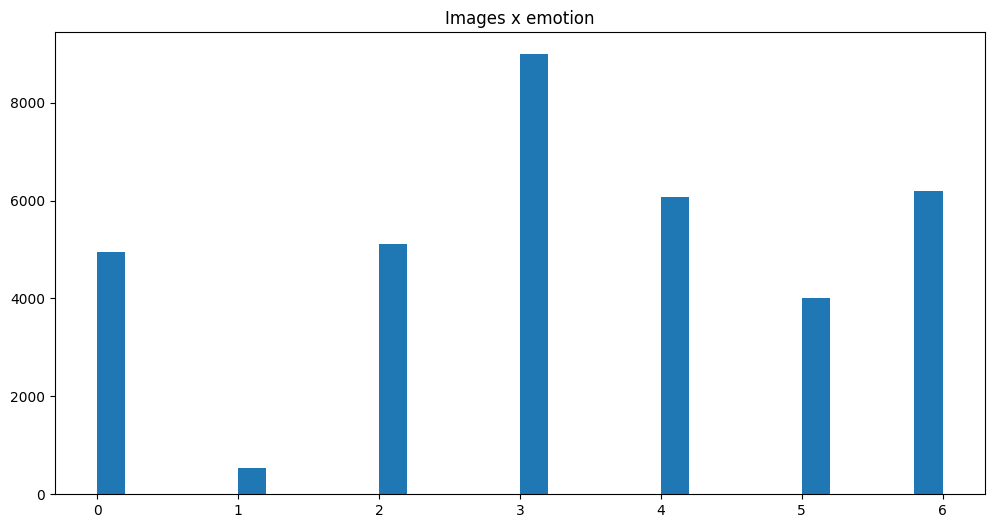

In [3]:
# visualizando a representatividade do dataset
plt.figure(figsize=(12, 6)) # cria uma figura de 12x6 polegadas
plt.hist(data['emotion'], bins=30) # exibe as classes em um histograma
plt.title('Images x emotion')
plt.show()

Classes: <br>
0 - Angry<br>
1 - Disgust<br>
2 - Fear
3 - Happy<br>
4 - Sad<br>
5 - Suprise<br>
6 - Neutral<br>

emotion
3    1.631346
6    0.452488
4    0.401380
2   -0.002414
0   -0.073373
5   -0.475055
1   -1.934372
Name: count, dtype: float64


<BarContainer object of 7 artists>

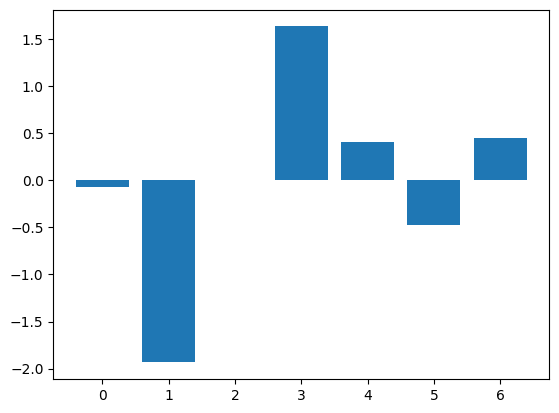

In [4]:
from scipy.stats import zscore
value_counts = data['emotion'].value_counts()
zscores = zscore(value_counts)
print(zscores)
plt.bar(zscores.index, zscores.values)

Podemos notar que a classe de nojo (disgust) está bem menos representada do que a média, tendo um Z-Score de quase -2. Um processo de Data Augmentation será necessário para que o modelo treinado com esses dados seja capaz de reconhecer a expressões de nojo com precisão.

# Pré-processamento

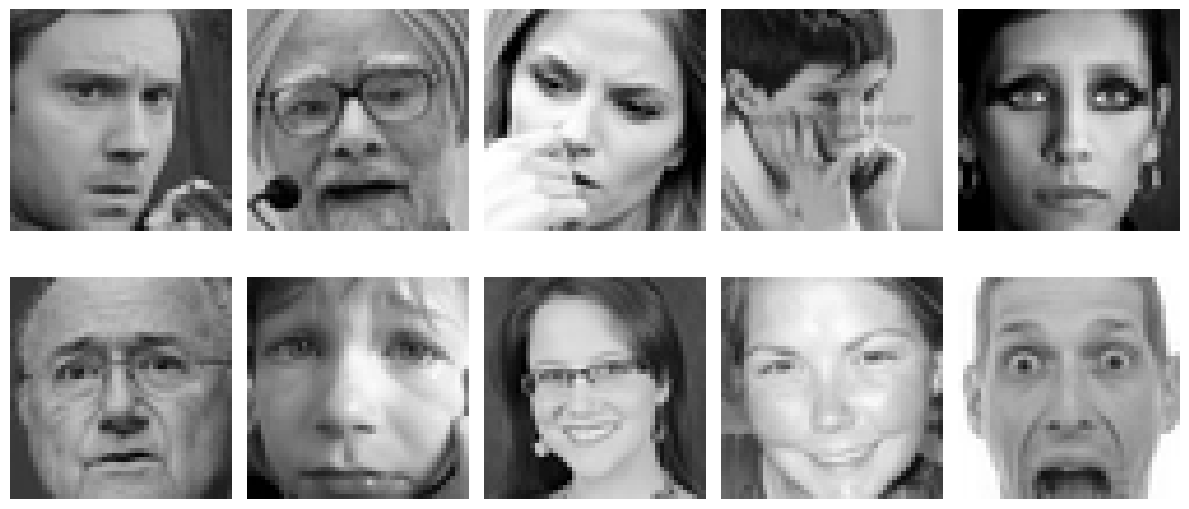

[[[[0.27450982]
   [0.3137255 ]
   [0.32156864]
   ...
   [0.20392157]
   [0.16862746]
   [0.16078432]]

  [[0.25490198]
   [0.23921569]
   [0.22745098]
   ...
   [0.21960784]
   [0.20392157]
   [0.17254902]]

  [[0.19607843]
   [0.16862746]
   [0.21176471]
   ...
   [0.19215687]
   [0.21960784]
   [0.18431373]]

  ...

  [[0.35686275]
   [0.25490198]
   [0.16470589]
   ...
   [0.28235295]
   [0.21960784]
   [0.16862746]]

  [[0.3019608 ]
   [0.32156864]
   [0.30980393]
   ...
   [0.4117647 ]
   [0.27450982]
   [0.18039216]]

  [[0.3019608 ]
   [0.28235295]
   [0.32941177]
   ...
   [0.41568628]
   [0.42745098]
   [0.32156864]]]


 [[[0.5921569 ]
   [0.5882353 ]
   [0.5764706 ]
   ...
   [0.5058824 ]
   [0.54901963]
   [0.47058824]]

  [[0.5921569 ]
   [0.58431375]
   [0.58431375]
   ...
   [0.47843137]
   [0.5529412 ]
   [0.5372549 ]]

  [[0.5921569 ]
   [0.5921569 ]
   [0.6117647 ]
   ...
   [0.42745098]
   [0.48235294]
   [0.57254905]]

  ...

  [[0.7372549 ]
   [0.7372549 ]
   [0.4

In [5]:
pixels = data['pixels'].to_list() # pega a Series de pixels como uma lista
width, height = 48, 48 # largura e altura para o qual iremos converter cada imagem

faces = []
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for pixel_sequence in pixels: # itera por cada imagem (string)
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # converte para uma lista de inteiros
    face = np.asarray(face).reshape(width, height) # redimensiona a imagem para 48x48, exigido pelo classificador
    faces.append(face)
    
    if (i < 10):
        axes.flat[i].imshow(cv2.cvtColor(face.astype(np.uint8), cv2.COLOR_BGR2RGB))
        axes.flat[i].axis('off')
    i += 1
    
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
def normalizar(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

faces = normalizar(faces)
    
plt.tight_layout()
plt.show()
print(faces)

In [6]:
# extração das representações One-Hot:
emotions = pd.get_dummies(data['emotion'], dtype=np.uint8).to_numpy()
emotions

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [7]:
print(f'Total de imagens no dataset: {len(faces)}')

Total de imagens no dataset: 35887


# Importações do Tensorflow

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

# Organização dos dados

In [9]:
# criação dos conjuntos de treino, teste e validação:
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 41)

In [10]:
print(f'Número de imagens de treino: {len(X_train)}')
print(f'Número de imagens de teste: {len(X_test)}')
print(f'Número de imagens de validação: {len(X_val)}')

Número de imagens de treino: 29068
Número de imagens de teste: 3589
Número de imagens de validação: 3230


In [11]:
# salvando os conjuntos de teste como arquivos:
np.save('mod_xtest', X_test)
np.save('mod_ytest', y_test)

# Arquitetura da CNN

In [12]:
num_features = 32
num_classes = 7
width, height = 48, 48
batch_size = 64
epochs = 100

model = Sequential()

model.add(Conv2D(filters=num_features, kernel_size=(3,3), padding='same',
                 kernel_initializer = 'he_normal', # pesos inicias são tirados aleatoriamente de N(0, 2/(fan_in)), onde fan_in = n° de inputs na camada (neuronios da anterior)
                 input_shape=(width, height, 1)))
model.add(Activation('elu')) # exponential linear unit: x p/ x > 0; (1 - e^x) p/ x <= 0
model.add(BatchNormalization())
model.add(Conv2D(num_features, (3,3), padding='same', kernel_initializer='he_normal',
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# repete o bloco com o dobro de feature detector por convolução:
model.add(Conv2D(filters=2*num_features, kernel_size=(3,3), padding='same',
                 kernel_initializer = 'he_normal', # pesos inicias são tirados aleatoriamente de N(0, 2/(fan_in)), onde fan_in = n° de inputs na camada (neuronios da anterior)
                 input_shape=(width, height, 1)))
model.add(Activation('elu')) # exponential linear unit: x p/ x > 0; (1 - e^x) p/ x <= 0
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, (3,3), padding='same', kernel_initializer='he_normal',
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# repete o bloco dobrando o número de kernels novamente:
model.add(Conv2D(filters=2*2*num_features, kernel_size=(3,3), padding='same',
                 kernel_initializer = 'he_normal', # pesos inicias são tirados aleatoriamente de N(0, 2/(fan_in)), onde fan_in = n° de inputs na camada (neuronios da anterior)
                 input_shape=(width, height, 1)))
model.add(Activation('elu')) # exponential linear unit: x p/ x > 0; (1 - e^x) p/ x <= 0
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, (3,3), padding='same', kernel_initializer='he_normal',
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# novamente:
model.add(Conv2D(filters=2*2*2*num_features, kernel_size=(3,3), padding='same',
                 kernel_initializer = 'he_normal', # pesos inicias são tirados aleatoriamente de N(0, 2/(fan_in)), onde fan_in = n° de inputs na camada (neuronios da anterior)
                 input_shape=(width, height, 1)))
model.add(Activation('elu')) # exponential linear unit: x p/ x > 0; (1 - e^x) p/ x <= 0
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, (3,3), padding='same', kernel_initializer='he_normal',
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# rede neural densa:
model.add(Flatten()) # 48*48*8*32 valores
model.add(Dense(2*num_features, kernel_initializer='he_normal')) # 1a hidden layer
model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(2*num_features, kernel_initializer='he_normal')) # 2a hidden layer
model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax')) # softmax para problema multiclasse

print(model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,327,655 (5.06 MB)

 Trainable params: 1,325,735 (5.06 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


# Data Augmentation

In [18]:
X_train.shape

(29068, 48, 48, 1)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 30, # imagem pode rotacionar em até 30 graus
    shear_range=0.1, # alcance de cisalhamento das imagens
    zoom_range=0.3,
    width_shift_range=0.1, # faixa de deslocamento horizontal das imagens
    height_shift_range=0.1, # faixa de deslocamento vertical das imagens
    horizontal_flip=True, # aleatoriamente inverte as imagens na horizontal
    vertical_flip=True, # aleatoriamente inverte as imagens na vertical
    fill_mode='nearest' # preenche espaços fora da imagem (como os que sobram no width e height shift) com o valor do pixel mais próximo
)

train_generator = datagen.flow(X_train, y_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

In [14]:
model.compile(loss=categorical_crossentropy, # problema multiclasse com one-hot
             optimizer=Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
             metrics=['accuracy'])
model_file = 'modelo_02_expressoes_dataaug.weights.h5' # arquivo onde serão salvos os pesos do modelo treinado
model_file_json = 'modelo_02_expressoes_dataaug.json' # arquivo onde será salva a estrutura do modelo treinado
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', # monitora a validation loss
                              min_delta = 0, # qualquer melhora maior que 0 já é considerada
                              patience=8, # espera 8 epochs seguidas sem melhora antes de parar o treino
                              verbose=1, # imprime mensagens de progresso
                              mode='auto') # infere do nome da métrica monitorada se ela deve aumentar ou diminuir para ser considerado melhora
checkpointer = ModelCheckpoint(model_file, monitor='val_loss', verbose=1,
                               save_best_only=True, save_weights_only=True)

In [15]:
# salvando a arquitetura do modelo:
model_json = model.to_json() # converte o modelo para json
with open(model_file_json, 'w') as json_file: # abre o arquivo json no modo escrita
    json_file.write(model_json) # escreve o modelo em json no arquivo json

# Treinando e avaliando o modelo

In [22]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs = epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/100
450/454 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2188 - loss: 1.8525
Epoch 1: val_loss improved from 1.79897 to 1.76553, saving model to modelo_02_expressoes_dataaug.weights.h5
454/454 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.2190 - loss: 1.8522 - val_accuracy: 0.2706 - val_loss: 1.7655 - learning_rate: 0.0010
Epoch 2/100
  1/454 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1562 - loss: 1.8637
Epoch 2: val_loss did not improve from 1.76553
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.1562 - loss: 1.8637 - val_accuracy: 0.2700 - val_loss: 1.7667 - learning_rate: 0.0010
Epoch 3/100
453/454 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2448 - loss: 1.8115
Epoch 3: val_loss did not improve from 1.76553
454/454 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.2448 - loss: 1.8115 - val_accuracy: 0.2598 - val_loss: 1.7846 - learning_rate: 0.0010
Epoch 4/100
  1/454 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2031 - loss: 1.8205
Epoch 4: ReduceLR

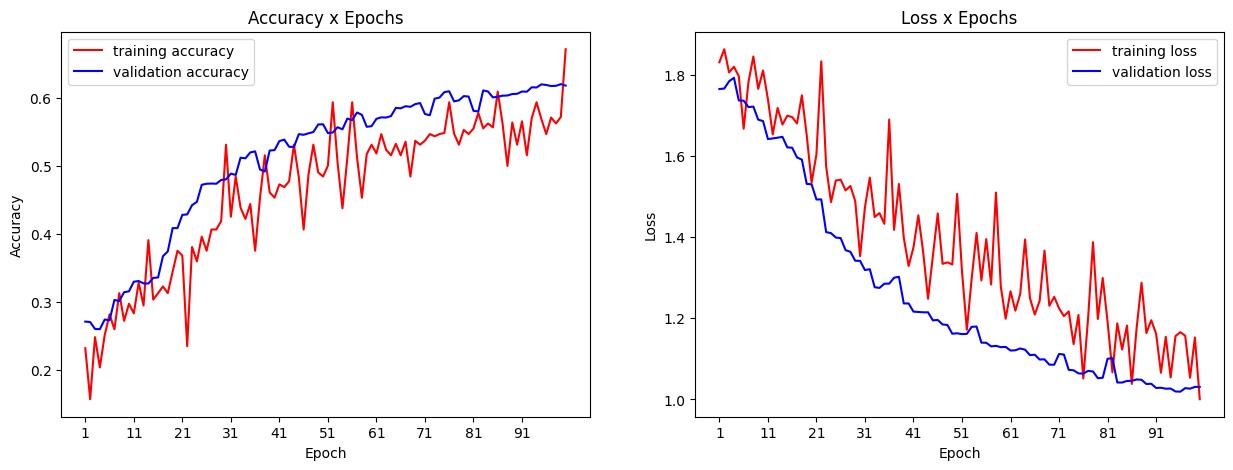

In [25]:
def plot_model_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axs[0].plot(range(1, len(history.history['accuracy']) + 1),
                history.history['accuracy'], 'r')
    axs[0].plot(range(1, len(history.history['val_accuracy']) + 1),
                history.history['val_accuracy'], 'b')
    axs[0].set_title('Accuracy x Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(history.history['accuracy']) + 1, max(1, len(history.history['accuracy']) // 10)))
    axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

    # Plot loss
    axs[1].plot(range(1, len(history.history['loss']) + 1),
                history.history['loss'], 'r')
    axs[1].plot(range(1, len(history.history['val_loss']) + 1),
                history.history['val_loss'], 'b')
    axs[1].set_title('Loss x Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(history.history['loss']) + 1, max(1, len(history.history['loss']) // 10)))
    axs[1].legend(['training loss', 'validation loss'], loc='best')
    
    fig.savefig('model_history_mod01.png')
    plt.show()
    
plot_model_history(history)